In [7]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (12, 10)

sns.set()

In [8]:
movie_df = pd.read_csv('movies.csv')
rating_df = pd.read_csv('ratings.csv')

In [9]:
movie_count = movie_df['id'].max() + 1
movie2userset = [set() for _ in range(movie_count)]

In [10]:
for row in rating_df.itertuples(index=True, name='Pandas'):
    movie2userset[row.movie_id].add(row.user_id)

In [11]:
G = nx.DiGraph()
G.add_nodes_from(range(movie_count), nodetype = int)

In [12]:
# threshold = 0.02
threshold = 0.6
for i in tqdm(range(movie_count)):
    for j in range(i + 1, movie_count):
        if len(movie2userset[i]) > 0:
            w = len(movie2userset[i] & movie2userset[j]) / len(movie2userset[i])
            if w > threshold:
                G.add_edge(i, j, weight=w)
                # count += 1
        if len(movie2userset[j]) > 0:
            w = len(movie2userset[i] & movie2userset[j]) / len(movie2userset[j])
            if w > threshold:
                G.add_edge(j, i, weight=w)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9742/9742 [01:00<00:00, 161.91it/s]

0


In [15]:
G.number_of_edges()
print(movie_count)

9742


In [20]:
in_edge_count = [len(G.in_edges(i)) for i in range(movie_count)]
in_edge_count = np.array(in_edge_count)

out_edge_count = [len(G.out_edges(i)) for i in range(movie_count)]
out_edge_count = np.array(out_edge_count)

In [25]:
zero_in_edge_node_count = (in_edge_count == 0).sum()
print(f'Nodes with 0 incoming edges : {zero_in_edge_node_count}')
zero_out_edge_node_count = (out_edge_count == 0).sum()
print(f'Nodes with 0 outgoing edges : {zero_out_edge_node_count}')

Nodes with 0 incoming edges : 110
Nodes with 0 outgoing edges : 21


In [40]:
# Normalize weights

for i in tqdm(range(movie_count)):
    total_w = sum(data['weight'] for u, v, data in G.out_edges(i, data=True))
    if total_w > 0:
        for u, v, data in G.out_edges(i, data=True):
            G[u][v]['weight'] = data['weight'] / total_w

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9742/9742 [00:08<00:00, 1147.50it/s]


In [46]:
result = nx.pagerank(G)

In [48]:
pgrank_id_pair_lst = [(value, key) for key, value in result.items()]

In [49]:
pgrank_id_pair_lst.sort(reverse=True)

In [50]:
pgrank_id_pair_lst

[(0.13162541282756018, 314),
 (0.1225365549920548, 257),
 (0.12019793828115316, 277),
 (0.10839821003798081, 510),
 (0.036014032892023845, 418),
 (0.017747954313674517, 1939),
 (0.017492736382458036, 224),
 (0.012253331220467048, 898),
 (0.01141165019628104, 507),
 (0.009759096360040574, 2226),
 (0.008602176070485665, 97),
 (0.008514291607618588, 911),
 (0.0068987063910515446, 900),
 (0.006822505491319296, 615),
 (0.005879273938275626, 398),
 (0.005565454000361738, 3638),
 (0.004684295139740429, 2145),
 (0.004323025796449321, 4137),
 (0.004189204690951107, 4800),
 (0.003755114850901534, 0),
 (0.0036300906162418257, 3194),
 (0.0032091565654219895, 969),
 (0.0030837570816392205, 509),
 (0.0030234687422370176, 2078),
 (0.0029774159456913544, 1503),
 (0.0028569152427570152, 4427),
 (0.002333611123171822, 43),
 (0.0022238853188473696, 1183),
 (0.002077820316369853, 659),
 (0.002059019308476781, 2674),
 (0.0019430085352785875, 520),
 (0.0018083307771041405, 337),
 (0.0017493625271961613, 436

In [52]:
top_movie_id_lst = [idx for pagerank, idx in pgrank_id_pair_lst[:50]]

In [57]:
movie_df

,id,movielens_id,title,genres,imdb_id,tmdb_id
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0
...,...,...,...,...,...,...
9737,9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0
9738,9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0
9739,9739,193585,Flint (2017),Drama,6397426,479308.0
9740,9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0


In [60]:
# movie_df[movie_df['id'] == top_movie_id_lst]
movie_df.query('id in @top_movie_id_lst')

,id,movielens_id,title,genres,imdb_id,tmdb_id
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
43,43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,114369,807.0
46,46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,114814,629.0
97,97,110,Braveheart (1995),Action|Drama|War,112573,197.0
123,123,150,Apollo 13 (1995),Adventure|Drama|IMAX,112384,568.0
224,224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,76759,11.0
257,257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,110912,680.0
277,277,318,"Shawshank Redemption, The (1994)",Crime|Drama,111161,278.0
314,314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,109830,13.0
334,334,377,Speed (1994),Action|Romance|Thriller,111257,1637.0


/home/seljuk/miniconda3/envs/cs529/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


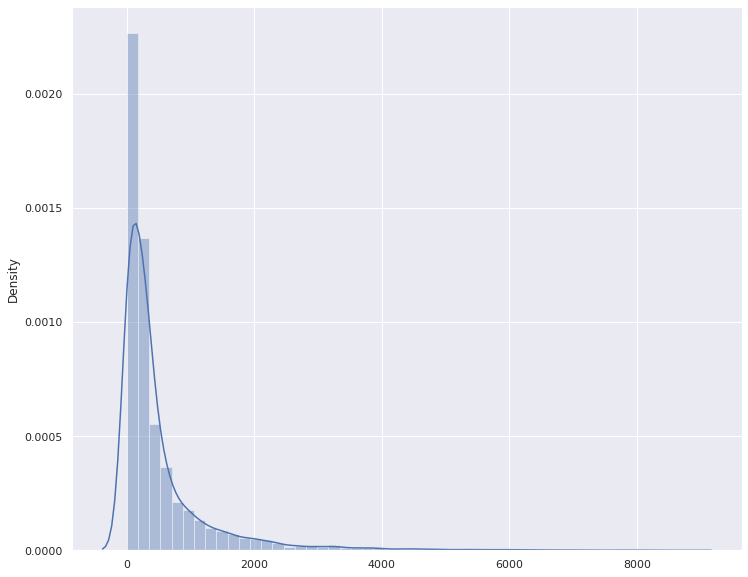

/home/seljuk/miniconda3/envs/cs529/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


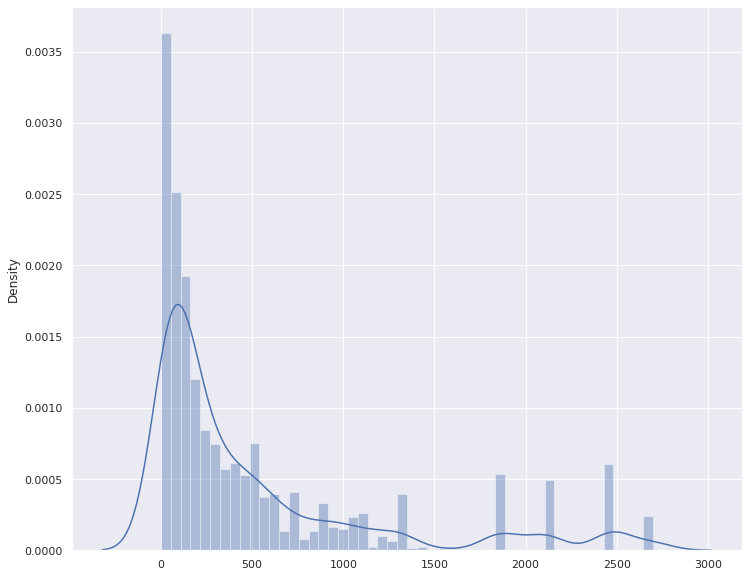

In [21]:
sns.distplot(in_edge_count)
plt.show()
sns.distplot(out_edge_count)
plt.show()

In [ ]:
# LEGACY CODE

w_lst = []
for i in tqdm(range(movie_count)):
    for j in range(i + 1, movie_count):
        if len(movie2userset[i]) > 0:
            w = len(movie2userset[i] & movie2userset[j]) / len(movie2userset[i])
        else:
            w = 0
        w_lst.append(w)
        if len(movie2userset[j]) > 0:
            w = len(movie2userset[i] & movie2userset[j]) / len(movie2userset[j])
        else:
            w = 0
        w_lst.append(w)
w_lst = np.array(w_lst)
w_lst_sample = np.random.choice(w_lst, size=1_000_000)
sns.distplot(w_lst_sample)